# Machine Vision 2022/23 - Assignment 2: Edge Detection and Hough Transform

In [1]:
import numpy as np
import skimage.io
import copy
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

#### Part 1: Edge Detection using Canny Filter

In this exercise, we want to identify which pixels belong to an edge. A common approach is the canny edge detection.
Therefore, you will partially implement the canny edge detection.

##### Preparation

First, load and display the test image which is stored in the resource directory `res/postit2g.png`.
Note: This is a gray-scale image, therefore, it has only one channel resulting in the shape `[v,u]`.

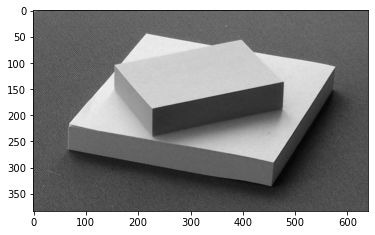

u=640, v=383


In [2]:
# @student: load and display the image.
# Note that plt.imshow(...) expects three channels (R,G,B).
# Hence, to correctly display gray-scale images the cmap argument should be set to "gray".
# (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
gray_img = skimage.io.imread("res/postit2g.png")
plt.imshow(gray_img, cmap="gray")
plt.show()

# @student: print the dimension of both u and v axis
print(f"u={gray_img.shape[1]}, v={gray_img.shape[0]}")

# ensure image is float type
gray_img = gray_img.astype(float)

Calculating the image gradient is an essential step in canny edge detection. It can be calculated using the convolution of the image with a special kernel.
For example the sobel kernel $K_s = \begin{bmatrix}-1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1\end{bmatrix}$.

##### Calculation

Your task is to calculate the gradient in u (`var: d_u`) and v (`var: d_v`) direction by specifying the correct kernel. Additionally, calculate the magnitude (`var: d_mag`) and the angle (`var: d_angle`) of the gradient.

For this, you need to implement the convolution operation. While calculating the convolution, the kernel slides over the image. Each multiplication/sum results in one new pixel.
However, if we want to maintain the image dimensions, a padding has to be inserted.

If we would not include a padding, the image dimensions would change.
In the Figure below this behavior is visualized for the calculation of pixel u=0, v=0.

<br></br>
<img src="./res/conv.jpeg" width="500" height="500">

In [3]:
# @student: implement convolution2d function
def convolution2d(*, img, kernel) -> np.ndarray:
    assert img.dtype == float, "Image must be in float"
    assert kernel.dtype == float, "Kernel must be in float"
    assert kernel.shape[0] == kernel.shape[1], "Kernel must be a square"
    assert kernel.shape[0] % 2 == 1, "Kernel size must be uneven"

    # @student: calculate the size of the padding required based on the kernel size:
    num_pad_pixels = ((kernel.shape[0] - 1) // 2)

    img_padded = copy.deepcopy(img)
    img_padded = np.pad(img_padded, num_pad_pixels)

    img_result = np.zeros_like(img)
    # @student: range over v dimension
    for v in range(num_pad_pixels, img_padded.shape[0] - num_pad_pixels):
        # @student: range over u dimension
        for u in range(num_pad_pixels, img_padded.shape[1] - num_pad_pixels):
            # @ student: extract the image patch based an u,v
            patch = img_padded[
                v-num_pad_pixels:v+num_pad_pixels+1,
                u-num_pad_pixels:u+num_pad_pixels+1
            ]

            # @student: perform convolution between image patch and kernel and store the
            img_result[v-num_pad_pixels,u-num_pad_pixels] = (patch * np.flip(kernel)).sum()
    return img_result

# @ student: define the sobel kernel
sobel_kernel = 1 / 8 * np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=float)

# This tests if your implementation is correct by comparing it against the implementation of scipy
result_own = convolution2d(img=gray_img, kernel=sobel_kernel)
result_scipy = convolve2d(gray_img, sobel_kernel, mode="same", fillvalue=0)
assert np.allclose(result_own, result_scipy), "Incorrect implementation of convolution2d()"

After you correctly implemented the convolution operation, you can calculate `d_u`, `d_v`, `d_mag`, and `d_angle`.

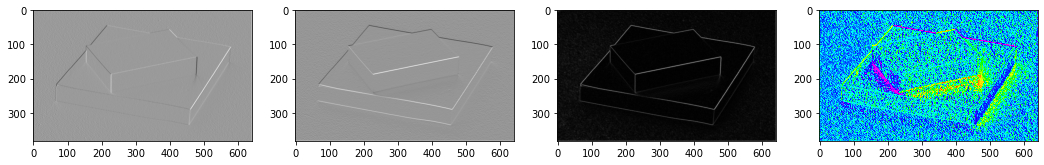

In [4]:
from typing import Tuple

def calculate_gradients(*, gray_img: np.ndarray, kernel_u: np.ndarray, kernel_v: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # @student: calculate d_u
    d_u = convolution2d(img=gray_img, kernel=kernel_u)
    # @student: calculate d_v
    d_v = convolution2d(img=gray_img, kernel=kernel_v)
    # @student: calculate d_mag
    d_mag = np.sqrt(np.square(d_u) + np.square(d_v))
    # @student: calculate the angle of the gradient
    d_angle = np.arctan2(d_u, d_v)

    return d_u, d_v, d_mag, d_angle

d_u, d_v, d_mag, d_angle = calculate_gradients(gray_img=gray_img, kernel_u=sobel_kernel, kernel_v=sobel_kernel.transpose())
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
figure_size = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(3 * figure_size)
ax1.imshow(d_u, cmap="gray")
ax2.imshow(d_v, cmap="gray")
ax3.imshow(d_mag, cmap="gray")
ax4.imshow(d_angle, cmap="hsv")
plt.show()

#### Part 2: Hough Transform

In this exercise, you will be given an implementation of the hough transform.

In [5]:
def hough_transform_tc(*, edge_image: np.ndarray, ps: np.ndarray, e=0.5) -> np.ndarray:
    t = ps[0]
    cos_t = np.cos(t)
    sin_t = np.sin(t)
    c = ps[1]

    acc = np.zeros_like(t)

    edge_pixel_idx = np.where(edge_image > 0)
    for idx in range(len(edge_pixel_idx[0])):
        x = edge_pixel_idx[1][idx]
        y = edge_pixel_idx[0][idx]

        res = x * cos_t + y * sin_t + c
        lines_on_point_idx = np.where(np.logical_and(res > -e, res < e))
        acc[lines_on_point_idx] += 1

    return acc

The image below shows a triangle that consists of three edges in total.
For simplicity, the image is already preprocessed and solely contains edge pixels.

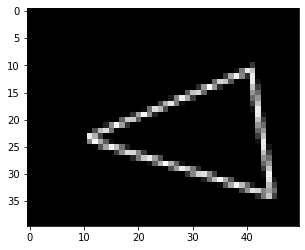

In [6]:
gray_img = skimage.io.imread("res/triangle.png")
plt.imshow(gray_img, cmap="gray")

The `hough_transform_tc` function implements the hough transform and expects two inputs:

- An image containing only edge pixels
- A parameter space containing all possible combinations of theta and c

The result of the function is an accumulator array which contains how many edge pixels each combination intersects with.

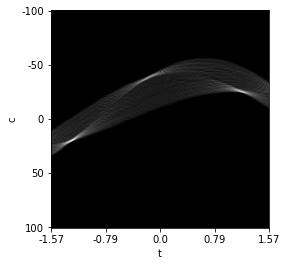

In [7]:
def span_tc_parameter_space(*, c_max: float, shape=(200,200)) -> np.ndarray:
    # @student: span values of theta over the desired range (-90.0 -> 90.0 degree in rad)
    thetas = np.deg2rad(np.linspace(-90.0, 90.0, shape[0]))
    # @student: span vales of c over the desired range
    c = np.linspace(-c_max, c_max, shape[1])

    return np.meshgrid(thetas, c)

t_c = span_tc_parameter_space(c_max=100, shape=(200,200))
acc_tc = hough_transform_tc(edge_image=gray_img, ps=t_c, e=0.5)

fig, ax = plt.subplots()
ax.imshow(acc_tc, cmap="gray")
ax.set_yticks(np.linspace(0, acc_tc.shape[1]-1, 5))
ax.set_yticklabels([-100,-50,0,50,100])
ax.set_ylabel("c")
ax.set_xticks(np.linspace(0, acc_tc.shape[1], 5))
ax.set_xticklabels(np.round(np.deg2rad([-90,-45,0,45,90]), 2))
ax.set_xlabel("t")
plt.savefig("v-")
plt.show()

The accumulator contains how many edge pixels a given line intersects. Therefore, the parameters that intersect the most pixels
in a local region are the best parametric representation for an edge. Hence, a local maxima in the accumulator represent the best approximations for the line parameters of edges.

Your task is to find these maxima within the accumulator array.

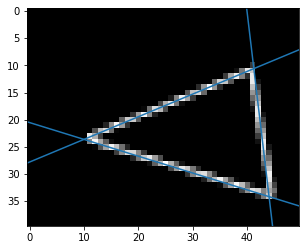

In [8]:
def local_peaks(*, acc, min_distance, num_peaks=3):
    # @student: implement some algorithm to find local maxima
    #           depending on your implementation you can change the arguments of the function
    acc_flat = acc.flatten()
    acc_sorted_ascending = acc_flat.argsort()
    acc_sorted_descending = np.flip(acc_sorted_ascending)

    found = 0
    index_found = []
    for idx in acc_sorted_descending:
        idx_2d = np.unravel_index(idx, acc.shape)

        # Check if peak is near another peak
        near_other_peak = False
        for idx_f in index_found:
            peak_distance = np.abs(idx_2d[0] - idx_f[0] + idx_2d[1] - idx_f[1])

            if peak_distance < min_distance:
                near_other_peak = True
                break

        if near_other_peak:
            continue

        found += 1
        index_found.append(idx_2d)
        if found >= num_peaks:
            break

    return index_found


def convert_acc_to_lines(*, acc, ps, num_peaks=3):
    # @student: return the line parameters of the num_peaks most prominent lines
    peaks = local_peaks(acc=acc, min_distance=10, num_peaks=num_peaks)

    lines = []
    for line_peak_idx in peaks:
        lines.append([
            ps[0][line_peak_idx[0], line_peak_idx[1]],
            ps[1][line_peak_idx[0], line_peak_idx[1]]
        ])

    return lines


def plot_lines(*, original_img, lines):
    fig = plt.figure()
    plt.imshow(original_img, cmap="gray")
    xmin, xmax = fig.gca().get_xbound()

    for t,c in lines:
        # @student: calculate the ymin and ymax value of the line visualization
        #           based on the line parameters and xmin and xmax
        ymin = (-xmin * np.cos(t) - c) / np.sin(t)
        ymax = (-xmax * np.cos(t) - c) / np.sin(t)

        l = matplotlib.lines.Line2D([xmin, xmax], [ymin, ymax])
        plt.gca().add_line(l)

    plt.show()
    return

edges = convert_acc_to_lines(acc=acc_tc, ps=t_c, num_peaks=3)
plot_lines(original_img=gray_img, lines=edges)